In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import torch as tn
import random
import warnings
import multiprocessing as mp
from functools import partial
from scipy.integrate import quad, IntegrationWarning
import time
from concurrent.futures import ThreadPoolExecutor


# Import files
from constants import *
from pdfpy import *
from functions import  d_sigma, d_sigma_sm, sigma_sm, sme
from rotation import *

LHAPDF 6.5.4 loading /home/ahmed/miniconda3/envs/env1/share/LHAPDF/NNPDF31_nnlo_as_0118/NNPDF31_nnlo_as_0118_0000.dat
NNPDF31_nnlo_as_0118 PDF set, member #0, version 1; LHAPDF ID = 303600


In [2]:
# Quarks
quarks = [
    (2, 2/3*e, 'u', 1/2),
     (1, -1/3*e, 'd', -1/2),
     (3, -1/3*e, 's', -1/2),
     (4, 2/3*e, 'c', 1/2),
      (5, -1/3*e, 'b', -1/2),
    #  (6, 2/3*e, 't', 1/2),
]

# List of quark properties and couplings
quark_couplings = []

for flavor, e_f, name, I3 in quarks:
    g_fR = -e_f * sin2th_w
    g_fL = I3 - e_f * sin2th_w
    
    # Rounding to 4 decimal places
    e_f = round(e_f, 4)
    g_fR = round(g_fR, 4)
    g_fL = round(g_fL, 4)
    
    quark_couplings.append((flavor, e_f, g_fR, g_fL))

print(quark_couplings)

[(2, 0.2019, -0.0467, 0.4533), (1, -0.1009, 0.0233, -0.4767), (3, -0.1009, 0.0233, -0.4767), (4, 0.2019, -0.0467, 0.4533), (5, -0.1009, 0.0233, -0.4767)]


In [3]:
g = tn.tensor([
    [1,0,0,0],
    [0,-1,0,0],
    [0,0,-1,0],
    [0,0,0,-1]
], dtype=tn.float32)
CR = tn.tensor([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
], dtype=tn.float32)

In [4]:
# Define the constant tensors once
A = 1 / np.sqrt(2)
p1 = A * tn.tensor([1, 0, 0, 1], dtype=tn.float32)
p2 = A * tn.tensor([1, 0, 0, -1], dtype=tn.float32)

# Precompute total number of steps

specific_time = datetime(2018, 1, 1, 0, 0)

start_time = int(specific_time.timestamp())

# start_time = int(time.time())
end_time = start_time + int(timedelta(days=1).total_seconds())
step_seconds = int(timedelta(hours=1).total_seconds())
num_steps = (end_time - start_time) // step_seconds

# Lists to store the times and contr matrix elements
times = []
contrelep1 = []
contrelep2 = []

R_y_lat = R_y(latitude)
R_x_azi = R_x(azimuth)

# Main loop
current_time = start_time
for _ in range(num_steps):
    # Convert current_time to a timestamp
    current_datetime = datetime.fromtimestamp(current_time)
    time_utc = current_datetime.timestamp()

    # Calculate omega_t
    omega_t_sid = omega_utc * time_utc + 3.2830 
    # Construct the complete rotation matrix from SCF to CMS
    R_Z_omega = R_Z(omega_t_sid)
    
    R_mat = tn.matmul(R_y_lat, tn.matmul(R_x_azi, tn.matmul(R_z, R_Z_omega)))
    R_matrix1 = tn.einsum('am,na->mn', g, R_mat)
    R_matrix2 = tn.einsum('ma,an->mn', g, R_mat)

    # Compute contrL and contrR using matrix multiplication
    contrp1 = tn.einsum('ij,j->i', R_matrix1, p1)
    contrp2 =  tn.einsum('ij,i->j',R_matrix2, p2)

    # Record the times and contr matrix elements
    times.append(current_time)
    contrelep1.append(contrp1)
    contrelep2.append(contrp2)


    # Move to the next time step
    current_time += step_seconds

In [5]:

# Create the linear values
linear_values = tn.linspace(-0.025, 0.025, steps=20)

# Initialize an empty list to hold the tensors
CL_values = []

# Loop through the linear values and create the tensors
for value in linear_values:
    tensor = tn.zeros((4, 4))  # Create a tensor of the specified size, filled with zeros
    tensor[2, 3] = value  # Set the value at the first index
    tensor[3, 2] = value  # Set the value at the second index
    CL_values.append(tensor)


In [6]:
def generate_cl_sme_code(num_cl=20):
    cl_assignment_code = ""
    sme_computation_code = ""
    result_dict_code = "    return {\n"

    for i in range(0, num_cl ):
        cl_assignment_code += f"    CL{i+1} = CL_values[{i}]\n"
        sme_computation_code += f"    result_sme{i+1} = sme(Q_min, Q_max, CL{i+1}, CR, pm, pn, quark_couplings)\n"
        result_dict_code += f"        'result_sme{i+1}': result_sme{i+1},\n"

    result_dict_code = result_dict_code.rstrip(",\n") + "\n    }"

    full_code = f"{cl_assignment_code}\n{sme_computation_code}\n{result_dict_code}"
    return full_code

# Example usage:
generated_code = generate_cl_sme_code()
print(generated_code)


    CL1 = CL_values[0]
    CL2 = CL_values[1]
    CL3 = CL_values[2]
    CL4 = CL_values[3]
    CL5 = CL_values[4]
    CL6 = CL_values[5]
    CL7 = CL_values[6]
    CL8 = CL_values[7]
    CL9 = CL_values[8]
    CL10 = CL_values[9]
    CL11 = CL_values[10]
    CL12 = CL_values[11]
    CL13 = CL_values[12]
    CL14 = CL_values[13]
    CL15 = CL_values[14]
    CL16 = CL_values[15]
    CL17 = CL_values[16]
    CL18 = CL_values[17]
    CL19 = CL_values[18]
    CL20 = CL_values[19]

    result_sme1 = sme(Q_min, Q_max, CL1, CR, pm, pn, quark_couplings)
    result_sme2 = sme(Q_min, Q_max, CL2, CR, pm, pn, quark_couplings)
    result_sme3 = sme(Q_min, Q_max, CL3, CR, pm, pn, quark_couplings)
    result_sme4 = sme(Q_min, Q_max, CL4, CR, pm, pn, quark_couplings)
    result_sme5 = sme(Q_min, Q_max, CL5, CR, pm, pn, quark_couplings)
    result_sme6 = sme(Q_min, Q_max, CL6, CR, pm, pn, quark_couplings)
    result_sme7 = sme(Q_min, Q_max, CL7, CR, pm, pn, quark_couplings)
    result_sme8 = sme(Q_min,

In [7]:
CL1 = CL_values[0]
CL2 = CL_values[1]
CL3 = CL_values[2]
CL4 = CL_values[3]
CL5 = CL_values[4]
CL6 = CL_values[5]
CL7 = CL_values[6]
CL8 = CL_values[7]
CL9 = CL_values[8]
CL10 = CL_values[9]
CL11 = CL_values[10]
CL12 = CL_values[11]
CL13 = CL_values[12]
CL14 = CL_values[13]
CL15 = CL_values[14]
CL16 = CL_values[15]
CL17 = CL_values[16]
CL18 = CL_values[17]
CL19 = CL_values[18]
CL20 = CL_values[19]

In [12]:
Q_min = 60
Q_max = 70 
result_sme2 = sme(Q_min, Q_max, CL2, CR, contrelep1[5], contrelep2[5], quark_couplings)
print(result_sme2)

-59.77790728802289


In [15]:
%%time

# Ignore specific warnings
warnings.simplefilter("ignore", IntegrationWarning)

def compute_result(args):
    pm, pn, quark_couplings, CL_1, CL_2, CL_3, CL_4, CR_ = args
    
    Q_min = 60
    Q_max = 70  
    
    # Compute the SME contributions
    result_sme1 = sme(Q_min, Q_max, CL_1, CR_, pm, pn, quark_couplings)
    result_sme2 = sme(Q_min, Q_max, CL_2, CR_, pm, pn, quark_couplings)
    result_sme3 = sme(Q_min, Q_max, CL_3, CR_, pm, pn, quark_couplings)
    result_sme4 = sme(Q_min, Q_max, CL_4, CR_, pm, pn, quark_couplings)

    # Return the result as a dictionary
    return {
        'result_sme1': result_sme1,
        'result_sme2': result_sme2,
        'result_sme3': result_sme3,
        'result_sme4': result_sme4,
    }

# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL1, CL2, CL3, CL4, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.map(compute_result, args_list)

# Further processing of `results` can be done here if needed.


Process ForkPoolWorker-59:
Process ForkPoolWorker-49:
Process ForkPoolWorker-61:
Process ForkPoolWorker-62:
Process ForkPoolWorker-63:
Process ForkPoolWorker-58:
Process ForkPoolWorker-53:
Process ForkPoolWorker-55:
Process ForkPoolWorker-50:
Process ForkPoolWorker-57:
Process ForkPoolWorker-52:
Process ForkPoolWorker-60:
Process ForkPoolWorker-64:
Process ForkPoolWorker-56:
Process ForkPoolWorker-54:
Process ForkPoolWorker-51:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ahmed/miniconda3/envs/env1/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ahmed/minic

KeyboardInterrupt: 

In [8]:
%%time
warnings.simplefilter("ignore", IntegrationWarning)

def compute_result2(args):
    pm, pn, quark_couplings, CL5, CL6, CL7, CL8, CR = args
    
    # Calculate Q^2
    Q_min = 60
    Q_max = 70  
    
    # Compute the SME contributions
    result_sme5 = sme(Q_min, Q_max, CL5, CR, pm, pn, quark_couplings)
    result_sme6 = sme(Q_min, Q_max, CL6, CR, pm, pn, quark_couplings)
    result_sme7 = sme(Q_min, Q_max, CL7, CR, pm, pn, quark_couplings)
    result_sme8 = sme(Q_min, Q_max, CL8, CR, pm, pn, quark_couplings)

    # Return the result as a dictionary
    return {
            'result_sme5': result_sme5,
            'result_sme6': result_sme6,
            'result_sme7': result_sme7,
            'result_sme8': result_sme8,

        }



# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL5 , CL6, CL7, CL8, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a partial function to include sigma_sm_value
partial_compute_result2 = partial(compute_result2)

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    # Pass the partial function to pool.map
    results2 = pool.map(partial_compute_result2, args_list)

Process ForkPoolWorker-22:
Process ForkPoolWorker-30:
Process ForkPoolWorker-24:
Process ForkPoolWorker-26:
Process ForkPoolWorker-32:
Process ForkPoolWorker-29:
Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
Process ForkPoolWorker-31:
Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-18:
Process ForkPoolWorker-25:
Process ForkPoolWorker-23:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ahmed/miniconda3/envs/env1/lib/python3.9/multiprocessing/process

KeyboardInterrupt: 

  File "/home/ahmed/Desktop/test (Copy)/cross section variation Q80/functions.py", line 67, in integrand2
    _, term2_plus_term3 = sigma_hat_prime(x, tau, C, p1, p2, flavor, Q2)
  File "/home/ahmed/miniconda3/envs/env1/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py", line 611, in _quad
    return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
  File "/home/ahmed/miniconda3/envs/env1/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py", line 464, in quad
    retval = _quad(func, a, b, args, full_output, epsabs, epsrel, limit,
  File "/home/ahmed/miniconda3/envs/env1/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py", line 611, in _quad
    return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
  File "/home/ahmed/miniconda3/envs/env1/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py", line 464, in quad
    retval = _quad(func, a, b, args, full_output, epsabs, epsrel, limit,
  File "/home/ahmed/miniconda3/envs/env

In [ ]:
%%time
warnings.simplefilter("ignore", IntegrationWarning)

def compute_result3(args):
    pm, pn, quark_couplings, CL9, CL10, CL11, CL12, CR = args
    
    # Calculate Q^2
    Q_min = 60
    Q_max = 70  
    
    # Compute the SME contributions
    result_sme9 = sme(Q_min, Q_max, CL9, CR, pm, pn, quark_couplings)
    result_sme10 = sme(Q_min, Q_max, CL10, CR, pm, pn, quark_couplings)
    result_sme11 = sme(Q_min, Q_max, CL11, CR, pm, pn, quark_couplings)
    result_sme12 = sme(Q_min, Q_max, CL12, CR, pm, pn, quark_couplings)

    # Return the result as a dictionary
    return {
            'result_sme9': result_sme9,
            'result_sme10': result_sme10,
            'result_sme11': result_sme11,
            'result_sme12': result_sme12,

        }



# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL9 , CL10, CL11, CL12, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a partial function to include sigma_sm_value
partial_compute_result3 = partial(compute_result3)

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    # Pass the partial function to pool.map
    results3 = pool.map(partial_compute_result3, args_list)

In [ ]:
%%time
warnings.simplefilter("ignore", IntegrationWarning)

def compute_result4(args):
    pm, pn, quark_couplings, CL13, CL14, CL15, CL16, CR = args
    
    # Calculate Q^2
    Q_min = 60
    Q_max = 70  
    
    # Compute the SME contributions
    result_sme13 = sme(Q_min, Q_max, CL13, CR, pm, pn, quark_couplings)
    result_sme14 = sme(Q_min, Q_max, CL14, CR, pm, pn, quark_couplings)
    result_sme15 = sme(Q_min, Q_max, CL15, CR, pm, pn, quark_couplings)
    result_sme16 = sme(Q_min, Q_max, CL16, CR, pm, pn, quark_couplings)

    # Return the result as a dictionary
    return {
            'result_sme13': result_sme13,
            'result_sme14': result_sme14,
            'result_sme15': result_sme15,
            'result_sme16': result_sme16,

        }



# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL13 , CL14, CL15, CL16, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a partial function to include sigma_sm_value
partial_compute_result4 = partial(compute_result4)

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    # Pass the partial function to pool.map
    results4 = pool.map(partial_compute_result4, args_list)

In [ ]:
%%time
warnings.simplefilter("ignore", IntegrationWarning)

def compute_result5(args):
    pm, pn, quark_couplings, CL17, CL18, CL19, CL20, CR = args
    
    # Calculate Q^2
    Q_min = 60
    Q_max = 70  
    
    # Compute the SME contributions
    result_sme17 = sme(Q_min, Q_max, CL17, CR, pm, pn, quark_couplings)
    result_sme18 = sme(Q_min, Q_max, CL18, CR, pm, pn, quark_couplings)
    result_sme19 = sme(Q_min, Q_max, CL19, CR, pm, pn, quark_couplings)
    result_sme20 = sme(Q_min, Q_max, CL20, CR, pm, pn, quark_couplings)

    # Return the result as a dictionary
    return {
            'result_sme17': result_sme17,
            'result_sme18': result_sme18,
            'result_sme19': result_sme19,
            'result_sme20': result_sme20,

        }



# Prepare the arguments for parallel processing
args_list = [(pm, pn, quark_couplings, CL17 , CL18, CL19, CL20, CR) 
             for (pm, pn) in zip(contrelep1, contrelep2)]

# Create a partial function to include sigma_sm_value
partial_compute_result5 = partial(compute_result5)

# Create a multiprocessing Pool
with mp.Pool(mp.cpu_count()) as pool:
    # Pass the partial function to pool.map
    results5 = pool.map(partial_compute_result5, args_list)

In [13]:
def convto_hours(timestamps):
    start_time = timestamps[0]  # The start time to normalize
    return [(t - start_time) / 3600 for t in timestamps]  # Convert seconds to hours

# Perform conversion
hours_start = convto_hours(times)

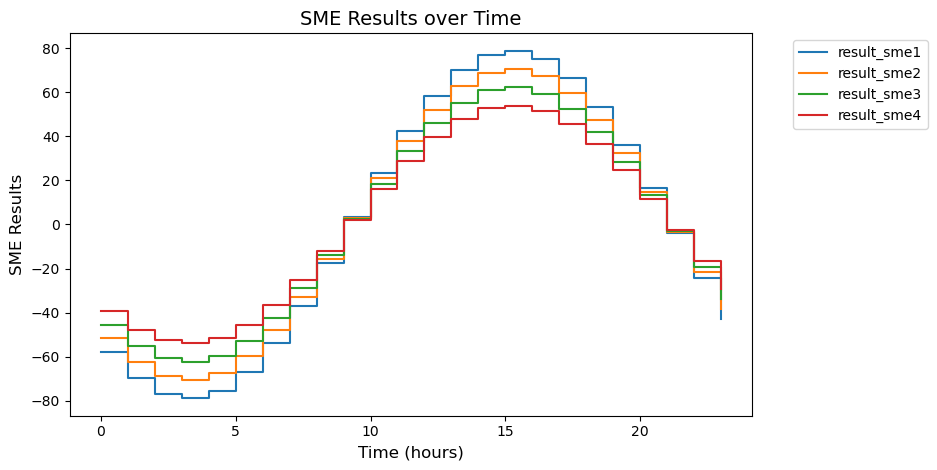

In [15]:
# Extract the results into arrays
dratios = [np.array([result[f'result_sme{i}'] for result in results]) for i in range(1, num_results+1)]
hours_array = np.array(hours_start)

plt.figure(figsize=(12, 6))

# Plot data using a loop
for i, dratio in enumerate(dratios, start=1):
    plt.step(hours_array, dratio, where='post', label=f'result_sme{i}', linewidth=1.5)

# Adding labels and title 
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('SME Results', fontsize=12)
plt.title('SME Results over Time', fontsize=14)

# Customizing the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout(rect=[0, 0, 0.8, 0.8]) 

# Showing the plot
plt.show()

In [14]:
# Determine the number of result_sme entries dynamically
num_results = len(results[0])  # Assuming all results have the same keys

# Extract the results into arrays
dratios = [np.array([result[f'result_sme{i}'] for result in results]) for i in range(1, 20)]
hours_array = np.array(hours_start)

plt.figure(figsize=(12, 6))

# Plot data using a loop
for i, dratio in enumerate(dratios, start=1):
    plt.step(hours_array, dratio, where='post', label=f'result_sme{i}', linewidth=1.5)

# Adding labels and title 
plt.xlabel('Time (hours)', fontsize=12)

# Customizing the legend

# Customize ticks

plt.tight_layout(rect=[0, 0, 0.8, 0.8]) 

# Showing the plot
# plt.savefig("liv.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

KeyError: 'result_sme5'

In [ ]:
import numpy as np

np.save("result_sme.npy", result_sme)


In [17]:
print(results)

[{'result_sme1': -57.65989983565616, 'result_sme2': -51.59047550278136, 'result_sme3': -45.520984209426885, 'result_sme4': -39.45149243100173}, {'result_sme1': -69.66509810275012, 'result_sme2': -62.331980004060085, 'result_sme3': -54.998787059600936, 'result_sme4': -47.66556930640906}, {'result_sme1': -76.89692670191721, 'result_sme2': -68.80246752634199, 'result_sme3': -60.708018397727855, 'result_sme4': -52.613637756916184}, {'result_sme1': -78.85966415194109, 'result_sme2': -70.5586046514095, 'result_sme3': -62.257626642027695, 'result_sme4': -53.956601288969196}, {'result_sme1': -75.41895686386931, 'result_sme2': -67.48012170316906, 'result_sme3': -59.54119950684374, 'result_sme4': -51.60242437835575}, {'result_sme1': -66.81055865040499, 'result_sme2': -59.77790728802289, 'result_sme3': -52.745103636761314, 'result_sme4': -45.71250701339446}, {'result_sme1': -53.624302756489264, 'result_sme2': -47.9796284260949, 'result_sme3': -42.334971206210795, 'result_sme4': -36.69032208122485